In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import torchsummary
import torch.autograd.profiler as profiler
import PIL
from matplotlib import pyplot as plt
import numpy as np

import utils
from utils import AverageMeter
import datasets
from models import *

from losses import VGG16PartialLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [12]:
model = PartialSR(batch_norm=False).to(device)
x = torch.rand((64, 3, 32, 32)).to(device)
out, mask = utils.image_mask(x, 4)
out, mask = out.to(device), mask.to(device)
from torch.nn.functional import batch_norm

In [13]:
with profiler.profile(record_shapes=True, profile_memory=True, use_cuda=True) as prof:
    with profiler.record_function("model_inference"):
        model(out, mask)

In [16]:
prof.export_chrome_trace("trace.json")

(3, 16, 16)
(3, 64, 64)


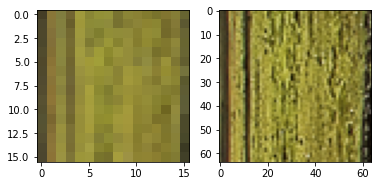

In [2]:
batch_size = 32
up_factor = 4
lr_res = 16
data_mult = 4
hr_res = lr_res * up_factor
div2k = datasets.Div2K(lr_res, up_factor, data_mult) # lr size, factor
training_set, validation_set, test_set = torch.utils.data.random_split(div2k, [640*data_mult,80*data_mult,80*data_mult])
lr, hr = div2k[6]
print(lr.shape)
print(hr.shape)
utils.showImages([lr, hr])


In [4]:
training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

model = PConvResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = VGG16PartialLoss().to(device)
# loss_func = torch.nn.L1Loss()

torchsummary.summary(model, input_size=[(3, 64, 64), (3, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     PartialConv2d-1  [[-1, 32, 64, 64], [-1, 32, 64, 64]]             896
     PartialConv2d-2  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
     PartialConv2d-3  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
     PConvResidual-4  [[-1, 32, 64, 64], [-1, 32, 64, 64]]               0
     PartialConv2d-5  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
     PartialConv2d-6  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
     PConvResidual-7  [[-1, 32, 64, 64], [-1, 32, 64, 64]]               0
     PartialConv2d-8  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
     PartialConv2d-9  [[-1, 32, 64, 64], [-1, 32, 64, 64]]           9,248
    PConvResidual-10  [[-1, 32, 64, 64], [-1, 32, 64, 64]]               0
    PartialConv2d-11  [[-1, 3, 64, 64], [-1, 3, 64, 64]]             867
Total params: 57,251
Trainable params: 57,251
No

In [5]:
# basic training loop
for epoch in range(8):
    for i, batch in enumerate(training_dataloader):
        # TODO make sure ops happen on GPU, unless the speed isn't affected
        optimizer.zero_grad()

        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled, mask_in = image_mask(lr, up_factor)

        pred, mask_out = model(upscaled.to(device), mask_in.to(device))
        loss, _, _ = loss_func(pred, hr) # VGG style loss

        loss.backward()

        optimizer.step()

        # print(i, loss)
    # basic validation loop
    print(f"Epoch {epoch}")
    validation_loss = AverageMeter("validation")
    for i, batch in enumerate(validation_dataloader):
        with torch.no_grad():
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)
            with torch.no_grad():
                upscaled, mask_in = image_mask(lr, up_factor)

            pred, mask_out = model(upscaled.to(device), mask_in.to(device))
            loss, _, _ = loss_func(pred, hr)
            validation_loss.update(loss.item())
            print(validation_loss)

TypeError: iteration over a 0-d tensor

In [11]:
# basic testing loop
print("Testing")
test_loss = AverageMeter("testing")
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled, mask_in = image_mask(lr, up_factor)

        pred, mask_out = model(upscaled.to(device), mask_in.to(device))
        loss, _, _ = loss_func(pred, hr)
        test_loss.update(loss.item())
        print(test_loss)

Testing
testing 5.132680 (5.132680)
testing 4.942405 (5.037542)
testing 5.933650 (5.336245)
testing 5.362090 (5.342706)
testing 5.858405 (5.445846)
testing 4.709484 (5.323119)
testing 6.216874 (5.450798)
testing 7.394001 (5.693698)
testing 5.727924 (5.697501)
testing 5.231086 (5.650860)


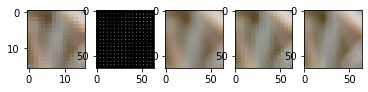

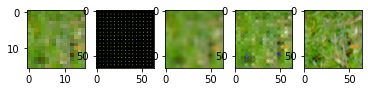

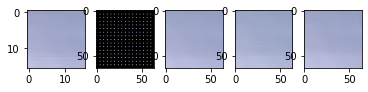

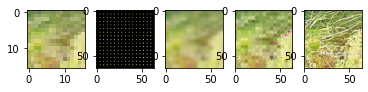

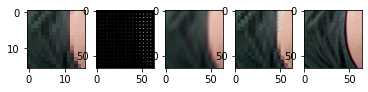

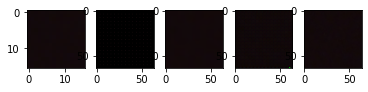

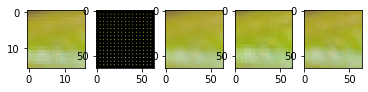

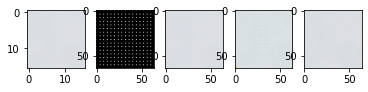

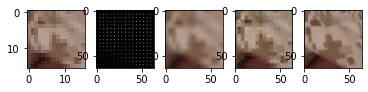

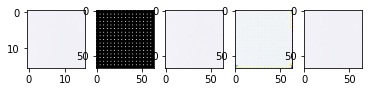

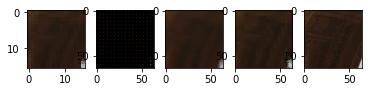

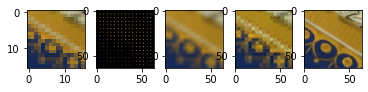

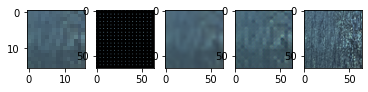

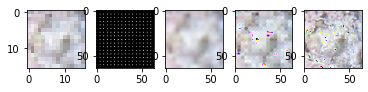

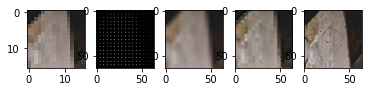

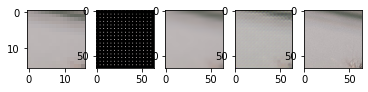

In [12]:
for i in range(32,48):
    with torch.no_grad():
        lr, hr = test_set[i]
        batch = utils.example_batch(torch.tensor(lr).to(device), batch_size)
        upscaled, mask_in = image_mask(batch, 4)
        pred, _ = model(upscaled.to(device), mask_in.to(device))
        bicubic = torchvision.transforms.functional.resize(torch.tensor(lr), (64,64))
        utils.showImages([np.asarray(lr), np.array(upscaled[0].cpu()), np.array(bicubic), np.array(pred[0].cpu()), hr])